<a href="https://colab.research.google.com/github/yuriao/DataScienceProjects/blob/main/linking_typing_to_score_lgbm_all_feat_engineered_singleModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install optuna

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
from scipy.stats import kurtosis, skew
from collections import Counter
import copy

from tqdm import tqdm
tqdm.pandas()

from lightgbm import LGBMRegressor
from sklearn import model_selection, metrics
from sklearn.preprocessing import LabelEncoder

import string
from nltk.corpus import stopwords

import optuna
from lightgbm.callback import log_evaluation, early_stopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Introduction

In this notebook, we will use LGBMRegressor to examine the score of writing based on typeing activities
- in this version only numeric typing features are used

In [ ]:
from google.colab import drive
drive.mount('typing_score_data')

Drive already mounted at typing_score_data; to attempt to forcibly remount, call drive.mount("typing_score_data", force_remount=True).


In [ ]:
train = pd.read_csv('/content/typing_score_data/MyDrive/typing_score_data/train_logs.csv')
train_score = pd.read_csv('/content/typing_score_data/MyDrive/typing_score_data/train_scores.csv')


# Preprocessing: encoding catagorical / verbal features, get feature/score matrixs

In [ ]:
class Preprocessor:
    def __init__(self):
        self.method_name=['sum','mean','std','max','median','skew','sem','kurtosis','quantile_90','quantile_70']
        self.numeric_features_ori=['event_id','down_time', 'up_time', 'action_time', 'cursor_position','word_count']
        self.numeric_features=['event_id','down_time', 'up_time', 'action_time', 'cursor_position','word_count']
        self.activity_type=['Input','Move','Nonproduction', 'Paste', 'Remove/Cut', 'Replace']
        self.event_type=['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-','.', '/', '0', '1', '2', '5', ':', ';', '<', '=', '>', '?', '@','A', 'Alt', 'AltGraph', 'ArrowDown', 'ArrowLeft', 'ArrowRight','ArrowUp', 'AudioVolumeDown', 'AudioVolumeMute', 'AudioVolumeUp','Backspace', 'C', 'Cancel', 'CapsLock', 'Clear', 'ContextMenu','Control', 'Dead', 'Delete', 'End', 'Enter', 'Escape', 'F', 'F1','F10', 'F11', 'F12', 'F15', 'F2', 'F3', 'F6', 'Home', 'I','Insert', 'Leftclick', 'M', 'MediaPlayPause', 'MediaTrackNext','MediaTrackPrevious', 'Meta', 'Middleclick', 'ModeChange','NumLock', 'OS', 'PageDown', 'PageUp', 'Pause', 'Process','Rightclick', 'S', 'ScrollLock', 'Shift', 'Space', 'T', 'Tab','Unidentified', 'Unknownclick', 'V', '[', '\\', ']', '^', '_', '`','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm','n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','{', '|', '}', '~', '\x80', '\x96', '\x97', '\x9b', '¡', '¿', 'Â´','Ä±', 'Å\x9f', 'Ë\x86', 'â\x80\x93', 'ä']
        #self.punctuations = stopwords.words('english')
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/','@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.selected_text_chg=['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.gaps=[1, 2, 3, 5, 10, 20]
    def quantile90(self,df):
        return df.quantile(0.90)

    def quantile70(self,df):
        return df.quantile(0.70)

    def time_gap_feats(self,df):
        for gap in tqdm(self.gaps):
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
            df[f'action_abs_time_gap{gap}'] = np.abs(df['down_time'] - df[f'up_time_shift{gap}'])
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)
        self.numeric_features.extend([f'action_time_gap{gap}' for gap in self.gaps])
        self.numeric_features.extend([f'action_abs_time_gap{gap}' for gap in self.gaps])
        return df

    def gap_feats(self,df,colname):
        for gap in tqdm(self.gaps):
            df[f'{colname}_shift{gap}'] = df.groupby('id')[colname].shift(gap);
            df[f'{colname}_change{gap}'] = df[colname] - df[f'{colname}_shift{gap}'];
            df[f'{colname}_abs_change{gap}'] = np.abs(df[colname] - df[f'{colname}_shift{gap}']);
        df.drop([f'{colname}_shift{gap}' for gap in self.gaps], axis=1)
        self.numeric_features.extend([f'{colname}_change{gap}' for gap in self.gaps])
        self.numeric_features.extend([f'{colname}_abs_change{gap}' for gap in self.gaps])
        return df

    def non_numeric_counts(self,df,colname,type_list):
        # 1. change move log to 'Move' if doing activity
        if colname == 'activity':
            activity_list=list(df[colname])
            for i in range(0,len(activity_list)):
                if 'Move' in activity_list[i]:
                    activity_list[i]='Move'
            df[colname]=activity_list

        # 2. count the freq of each type of entry
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in type_list:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols
        ret['id']=tmp_df['id']
        ret=ret.fillna(0)
        return ret

    def match_punctuations(self,df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        ret['id']=tmp_df['id']
        ret=ret.fillna(0)
        return ret

    def text_change_feat(self,df):
        df.loc[train['text_change'].str.contains('=>'),'text_change']='q' # single character change
        tmp_df = df[(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_median'] = tmp_df['text_change'].apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_skew'] = tmp_df['text_change'].apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_kurtosis'] = tmp_df['text_change'].apply(lambda x: kurtosis([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df

    def preprocessing(self,df):
        # new dataframe
        df_res=pd.DataFrame({'id': df['id'].unique().tolist()})

        # gap feats
        df=self.time_gap_feats(df)
        df=self.gap_feats(df,'action_time')
        df=self.gap_feats(df,'cursor_position')
        df=self.gap_feats(df,'word_count')

        # stats feats
        for colname in tqdm(self.numeric_features):
            for idx,method in enumerate(['mean','std','max','median','skew','sem',pd.DataFrame.kurt,self.quantile90,self.quantile70]):
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{self.method_name[idx]}'})
                df_res = df_res.merge(tmp_df, on='id', how='left')

        # non numeric feats
        df_res=df_res.merge(self.non_numeric_counts(df,'activity',self.activity_type), on='id',how='left')
        df_res=df_res.merge(self.non_numeric_counts(df,'up_event',self.event_type), on='id',how='left')
        df_res=df_res.merge(self.non_numeric_counts(df,'down_event',self.event_type), on='id',how='left')
        df_res=df_res.merge(self.non_numeric_counts(df,'text_change',self.selected_text_chg), on='id',how='left')
        df_res=df_res.merge(self.match_punctuations(df), on='id',how='left')
        df_res=df_res.merge(self.text_change_feat(df), on='id',how='left')

        # ratios
        #df_res['up_down_ratio']=df_res['up_time_mean']/df_res['down_time_mean']
        #df_res['cursor_action_ratio']=df_res['cursor_position_mean']/df_res['action_time_mean']
        #df_res['input_cursor_ratio']=df_res['input_word_length_mean']/df_res['cursor_position_max']
        #df_res['input_cursor_skew_ratio']=df_res['input_word_length_skew']/df_res['cursor_position_skew']
        #df_res['input_action_ratio']=df_res['input_word_length_mean']/df_res['action_time_mean']
        #df_res['input_cursor_skew_ratio']=df_res['cursor_position_max']/df_res['input_word_length_max']

        df_res['word_time_ratio']  = df_res['word_count_max'] / df_res['up_time_max'];
        df_res['word_event_ratio'] = df_res['word_count_max'] / df_res['event_id_max'];
        df_res['event_time_ratio'] = df_res['event_id_max']  / df_res['up_time_max'];
        df_res['idle_time_ratio']  = df_res['action_time_abs_change1_mean'] / df_res['up_time_max'];

        # restore
        self.numeric_features=self.numeric_features_ori # in this way the preprocessor will not produce duplicated cols for test

        return df_res

In [ ]:
preprocessor=Preprocessor()

In [ ]:
all_train_features_full_ori=preprocessor.preprocessing(train)
train_score_ori=copy.deepcopy(train_score)

100%|██████████| 2471/2471 [00:00<00:00, 5548.67it/s]


# multiple types of training data

In [ ]:
all_train_features_types=[]
train_score_types=[]

# ordinary, always 0
all_train_features_types.append(all_train_features_full_ori)
train_score_types.append(train_score_ori)

# middle score spec
all_train_features_tmp=all_train_features_full_ori.merge(train_score_ori,on='id',how='left')
idx=(all_train_features_tmp['score']>=2.5) & (all_train_features_tmp['score']<=5)
all_train_features_types.append(all_train_features_tmp.loc[idx,:].drop('score',axis=1))
train_score_types.append(train_score_ori.loc[idx,:])

# edge score spec
all_train_features_tmp=all_train_features_full_ori.merge(train_score_ori,on='id',how='left')
idx=(all_train_features_tmp['score']<2.5) | (all_train_features_tmp['score']>5)
all_train_features_types.append(all_train_features_tmp.loc[idx,:].drop('score',axis=1))
train_score_types.append(train_score_ori.loc[idx,:])


## LGBM model training func

In [ ]:
def KFold_model_training(train_feats,train_score,params):

    Y_pred=[]
    Y_ori=[]
    df_importance_list=[]
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    final_models=[]

    for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(train_feats)):
        X_train = train_feats.iloc[trn_idx,:]
        Y_train = train_score.iloc[trn_idx]

        X_val = train_feats.iloc[val_idx,:]
        Y_val = train_score.iloc[val_idx]

        print('\nFold_{} Training ================================\n'.format(fold_id+1))
        model= LGBMRegressor(**params)
        lgb_model = model.fit(X_train,
                              Y_train,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                              eval_metric='rmse')

        pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)


        df_importance = pd.DataFrame({
            'column': list(train_feats.columns),
            'importance': lgb_model.feature_importances_,
        })
        df_importance_list.append(df_importance)

        final_models.append(lgb_model)
        Y_pred.extend(pred_val)
        Y_ori.extend(Y_val)

    df_importance = pd.concat(df_importance_list)
    df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

    return Y_pred, Y_ori, df_importance, final_models


## Hyperparameter optimization with Optuna

In [ ]:
def objective(trial):

    param = {
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 1,1000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.00001,0.00005,0.001,0.005,0.01,0.02,0.05,0.1]),
        'max_depth': trial.suggest_int('max_depth', 1 , 200),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'vervose' : -1
    }


    Y_pred, Y_ori, df_importance, final_models = KFold_model_training(data,target,param);

    rmse = metrics.mean_squared_error(Y_ori, Y_pred,squared=False)

    return rmse

In [ ]:

#studies=[]

#for i in range(0,len(all_train_features_types)):
#    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
#    study = optuna.create_study(direction='minimize')
#    data=copy.deepcopy(all_train_features_types[i])
#    target=copy.deepcopy(train_score_types[i])
#    data=data.drop('id',axis=1)
#    target=target['score']

#    study.optimize(objective, n_trials=100)
#    studies.append(study)

In [ ]:
#best_params=[]
#for i in range(0,len(studies)):
#    print(f'Number of finished trials: {len(studies[i].trials)}')
#    print(f'Best trial: {studies[i].best_trial.params}')
#    print(f'Best score: {studies[i].best_value}')
#    best_params.append(studies[i].best_trial.params)

In [ ]:
#best_params={'n_estimators': 636, 'reg_alpha': 0.012184436950722766, 'reg_lambda': 0.701608495535993, 'colsample_bytree': 0.1, 'subsample': 0.1, 'learning_rate': 0.01, 'max_depth': 200, 'num_leaves': 927, 'min_child_samples': 66, 'min_data_per_groups': 11}
best_params1={'n_estimators': 636, 'reg_alpha': 0.012184436950722766, 'reg_lambda': 0.701608495535993, 'colsample_bytree': 0.1, 'subsample': 0.1, 'learning_rate': 0.01, 'max_depth': 200, 'num_leaves': 927, 'min_child_samples': 66, 'min_data_per_groups': 11}
best_params2={'n_estimators': 859, 'reg_alpha': 0.3442320671592016, 'reg_lambda': 0.033405170198758535, 'colsample_bytree': 0.2, 'subsample': 0.1, 'learning_rate': 0.01, 'max_depth': 23, 'num_leaves': 6, 'min_child_samples': 94, 'min_data_per_groups': 14}
best_params3={'n_estimators': 974, 'reg_alpha': 0.006121631269714688, 'reg_lambda': 0.06156250640380793, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.005, 'max_depth': 122, 'num_leaves': 971, 'min_child_samples': 9, 'min_data_per_groups': 65}
best_params=[best_params1,best_params2,best_params3]

# cross-validation training (three models individually) and test

In [ ]:
def KFold_model_predict(final_models,test_feats):
    Y_pred=[]

    for model in final_models:
        pred_val = model.predict(test_feats)
        Y_pred.append(pred_val)

    return np.mean(np.array(Y_pred),axis=0), Y_pred


In [ ]:
errs=[]
errs_rmse=[]
importances=[]
test_scores=[]
preds=[]
for j in range(0,len(all_train_features_types)):

    errs_curr=[]
    errs_rmse_curr=[]
    importances_curr=[]
    test_scores_curr=[]
    preds_curr=[]
    for i in range(0,20):
        all_train_features,_,all_train_scores,_=train_test_split(all_train_features_types[j],train_score_types[j],test_size=0.3,shuffle=True)
        _,test,_,test_score=train_test_split(all_train_features_types[0],train_score_types[0],test_size=0.3,shuffle=True)

        test=all_train_features_types[0].loc[~all_train_features_types[0]['id'].isin(list(all_train_features['id'])),:]
        test_score=train_score_types[0].loc[~train_score_types[0]['id'].isin(list(all_train_scores['id'])),:]

        all_train_scores=all_train_scores.drop('id',axis=1)
        test_score=test_score.drop('id',axis=1)
        test_score=test_score['score']

        # training
        print(f'Fitting Model')
        Y_pred, Y_ori, df_importance, final_models = KFold_model_training(all_train_features.drop('id',axis=1),all_train_scores,best_params[j])

        test_id=test['id']
        test=test.drop('id',axis=1)

        predictions, Ypred = KFold_model_predict(final_models,test)
        errs_curr.append(np.sqrt((predictions-list(test_score))*(predictions-list(test_score))))
        errs_rmse_curr.append(mean_squared_error(predictions,test_score,squared=False))

        if i == 0:
          importances_curr=df_importance
        else:
          importances_curr=importances_curr.merge(df_importance,on='column',how='left')


        test_scores_curr.append(test_score)
        preds_curr.append(predictions)

    errs.append(errs_curr)
    errs_rmse.append(errs_rmse_curr)
    importances.append(importances_curr)
    test_scores.append(test_scores_curr)
    preds.append(preds_curr)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
print(np.mean(errs_rmse[0]))
print(np.mean(errs_rmse[1]))
print(np.mean(errs_rmse[2]))

0.6390925183426409
0.9240187456331175
1.291634575882705


array([[<Axes: title={'center': 'pred'}>]], dtype=object)

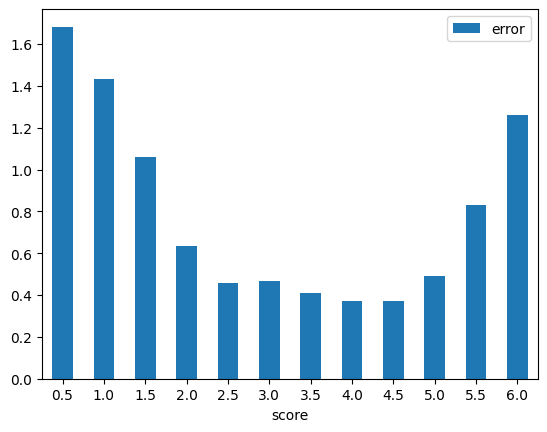

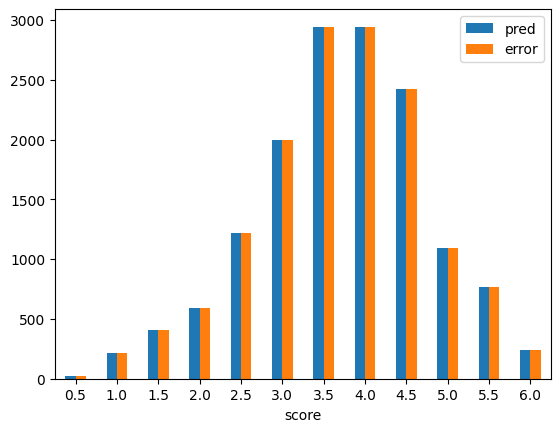

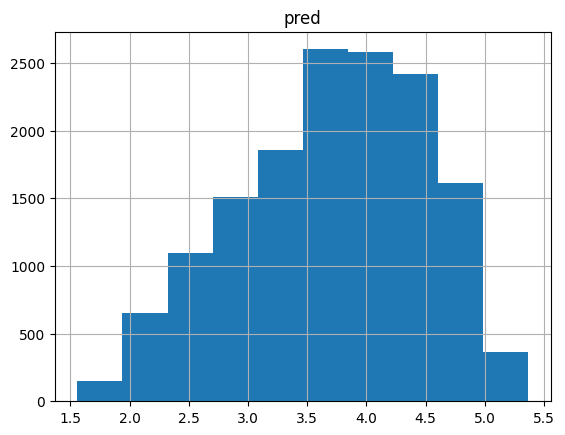

In [ ]:
typ=0
score_pred_err=pd.DataFrame(columns=['score','pred','error'])
score_pred_err['score']=np.hstack(test_scores[typ])
score_pred_err['pred']=np.hstack(preds[typ])
score_pred_err['error']=np.hstack(errs[typ])
score_err_perScore=score_pred_err.groupby('score').agg('mean').reset_index()
score_count=score_pred_err.groupby('score').agg('count').reset_index()
pred_count=score_pred_err.groupby('pred').agg('count').reset_index()
score_err_perScore.plot.bar(x='score', y='error', rot=0)
score_count.plot.bar(x='score', rot=0)
pred_count.hist('pred')

array([[<Axes: title={'center': 'pred'}>]], dtype=object)

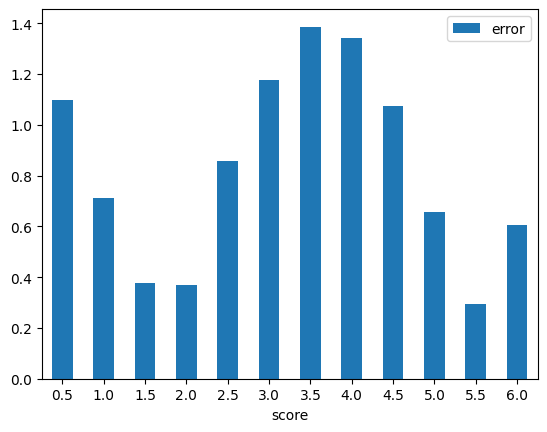

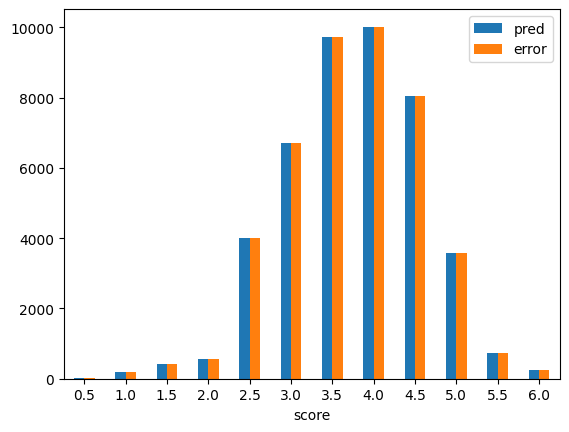

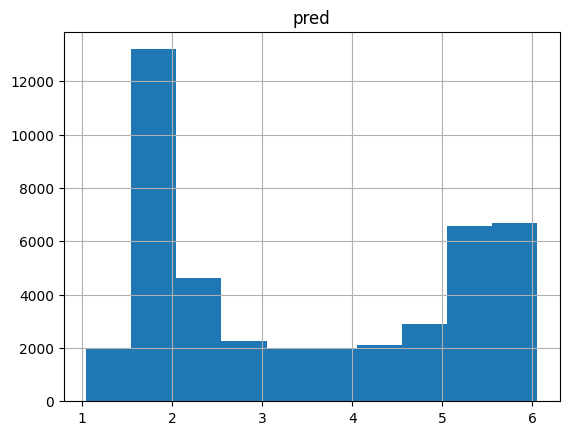

In [ ]:
typ=2
score_pred_err=pd.DataFrame(columns=['score','pred','error'])
score_pred_err['score']=np.hstack(test_scores[typ])
score_pred_err['pred']=np.hstack(preds[typ])
score_pred_err['error']=np.hstack(errs[typ])
score_err_perScore=score_pred_err.groupby('score').agg('mean').reset_index()
score_count=score_pred_err.groupby('score').agg('count').reset_index()
pred_count=score_pred_err.groupby('pred').agg('count').reset_index()
score_err_perScore.plot.bar(x='score', y='error', rot=0)
score_count.plot.bar(x='score', rot=0)
pred_count.hist('pred')

# cross-validation training (models ensemble) and test

In [ ]:
errs_2=[]
errs_rmse_2=[]
test_scores_2=[]
preds_2=[]
preds_all=[]
all_chg_amount=[]
all_chg_fraction=[]
for i in range(0,20):
    model_sets=[]
    all_ids=[]
    for j in [0,1,2]:
        all_train_features,_,all_train_scores,_=train_test_split(all_train_features_types[j],train_score_types[j],test_size=0.3,shuffle=True)
        all_ids.extend(list(all_train_features['id']))
        all_train_scores=all_train_scores.drop('id',axis=1)
        all_train_features=all_train_features.drop('id',axis=1)
        # training
        print(f'Fitting Model')
        Y_pred, Y_ori, df_importance, final_models = KFold_model_training(all_train_features,all_train_scores,best_params[j])
        model_sets.append(final_models)

    all_ids=np.unique(all_ids)
    test=all_train_features_types[0].loc[~all_train_features_types[0]['id'].isin(all_ids),:]
    test_score=train_score_types[0].loc[~train_score_types[0]['id'].isin(all_ids),:]

    test_score=test_score.drop('id',axis=1)
    test_score=test_score['score']

    test_id=test['id']
    test=test.drop('id',axis=1)

    predictions1, Ypred1 = KFold_model_predict(model_sets[0],test) # this is full model
    predictions2, Ypred2 = KFold_model_predict(model_sets[1],test) # this is low score model
    predictions3, Ypred3 = KFold_model_predict(model_sets[2],test) # this is low score model

    predictions=predictions1

    errs_2.append(np.sqrt((predictions-list(test_score))*(predictions-list(test_score))))
    errs_rmse_2.append(mean_squared_error(predictions,test_score,squared=False))

    test_scores_2.append(test_score)
    preds_2.append(predictions)
    preds_all.append([predictions1,predictions2,predictions3])


Streaming output truncated to the last 5000 lines.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103284
[LightGBM] [Info] Number of data points in the train set: 1178, number of used features: 521
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Start training from score 3.778014
[LightGBM] [Warning] Unknown parameter: min_data_per_groups

Fold_2 Training ================================

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103520
[LightGBM] [Info] Number of data points in the train set: 1178, number of used features: 522
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Start training from score 3.776316
[LightGBM] 

In [ ]:
print(np.mean(errs_rmse))



0.9515819466194878


array([[<Axes: title={'center': 'pred'}>]], dtype=object)

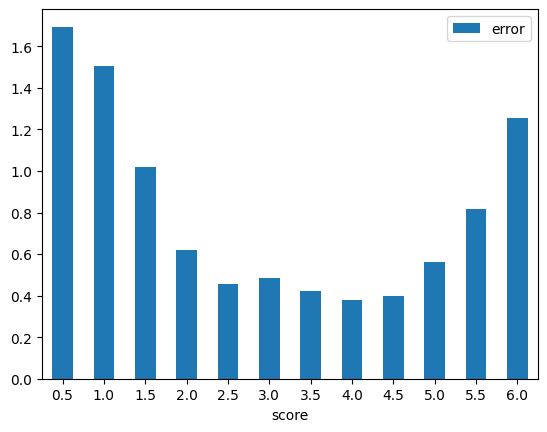

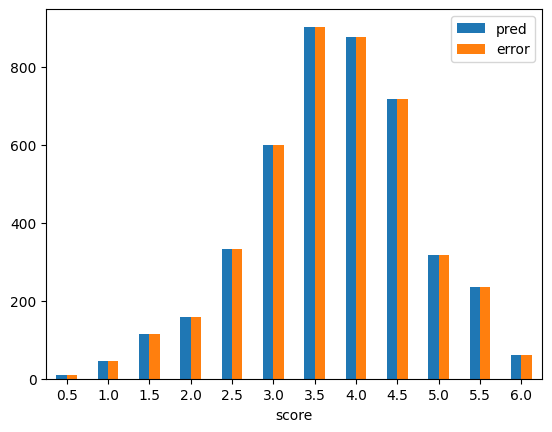

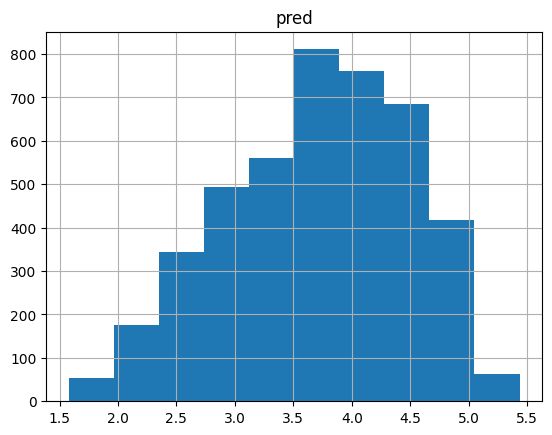

In [ ]:
score_pred_err=pd.DataFrame(columns=['score','pred','error'])
score_pred_err['score']=np.hstack(test_scores_2)
score_pred_err['pred']=np.hstack(preds_2)
score_pred_err['error']=np.hstack(errs_2)
score_err_perScore=score_pred_err.groupby('score').agg('mean').reset_index()
score_count=score_pred_err.groupby('score').agg('count').reset_index()
pred_count=score_pred_err.groupby('pred').agg('count').reset_index()
score_err_perScore.plot.bar(x='score', y='error', rot=0)
score_count.plot.bar(x='score', rot=0)
pred_count.hist('pred')